##Построить модель для предсказания стоимости автомобиля

**Функционал качества**
MAE - mean absolute error

**Файлы**

train_data.csv - данные для обучения

test_data.csv - данные для построения прогнозов цены

sample_submission.csv - образец файла, в который нужно вместо `0` в столбец `

final_price` подставить свои прогнозы

**Описание переменных:**

row_id - ID объекта

vehicle_manufacturer - компания-производитель автомобилей

vehicle_model - конкретная модель автомобиля

vehicle_category - тип транспортного средства

current_mileage - сколько километров машина уже проехала

vehicle_year - год выпуска автомобиля

vehicle_gearbox_type - тип коробки передач

doors_cnt - сколько дверей у машины

wheels - тип колеса (левое или правое)

vehicle_color - цвет кузова автомобиля

vehicle_interior_color - цвет салона автомобиля

car_vin - номер VIN

car_leather_interior - салон автомобиля кожаный

deal_type - тип сделки (для продаже или аренды)

final_price - цена автомобиля ( целевая переменная )

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

План анализа данных:
- загрузить данные для обучения
- обработать данные перед обучением модели
- обучить модель на обучающей выборке
- загрузить и предобработать данные для тестирования
- проанализировать модель на тестовой выборке

1. Загружаем датасет

In [2]:
df = pd.read_csv('train_data.csv')
df_t = pd.read_csv('test_data.csv')
df.head(5)

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

Посмотрим, сколько NaN в каждом столбце

In [4]:
df.isna().sum()

row_ID                        0
vehicle_manufacturer          1
vehicle_model                 7
vehicle_category              1
current_mileage               0
vehicle_year                  0
vehicle_gearbox_type          1
doors_cnt                   745
wheels                        1
vehicle_color               401
vehicle_interior_color     6718
car_vin                   23512
car_leather_interior          0
deal_type                     0
final_price                   0
dtype: int64

Имеем:
- 35000 строк
- 15 столбцоы

В данных присутствует три типа dtypes:

- int64 - целое число (4 столбца)
- float64 - дробное число (1 столбец)
- object - не число, обычно текст (10 столбцов)


В нашем случае признаки с типом object имеют текстовые значения.

Видно, что в данных содержатся пропуски, так как эти цифры не в каждой строчке совпадают с полным числом строк (35000).

В столбце vehicle_manufacturer присутствует один пропуск. Посмотрим на эту строчку:

In [5]:
df[df['vehicle_manufacturer'].isnull()]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
17918,17918,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,For Sale,0.0


Данная строка не дает нам никакой информации, поэтому можем удалить ее, так как она нам точно не нужна.

In [6]:
df = df.dropna(subset=['vehicle_manufacturer'])
df

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,4/5,Left wheel,Black,NaN,3FA6P0K98DR308742,1,For Sale,6000.0
34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,9642.0
34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,4/5,Left wheel,Grey,Grey,NaN,1,For Sale,23500.0
34998,34998,HYUNDAI,Tucson,Jeep,82139,2015,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,12826.0


Также замети, что в столбце car_vin большое количество NaN значений ( более 65%). удалим данный столбец.

In [7]:
df = df.drop(columns=['car_vin'], axis=1)

df_t = df_t.drop(columns=['car_vin'], axis=1)

Посмотрим на количество машин у каждого произволителя:

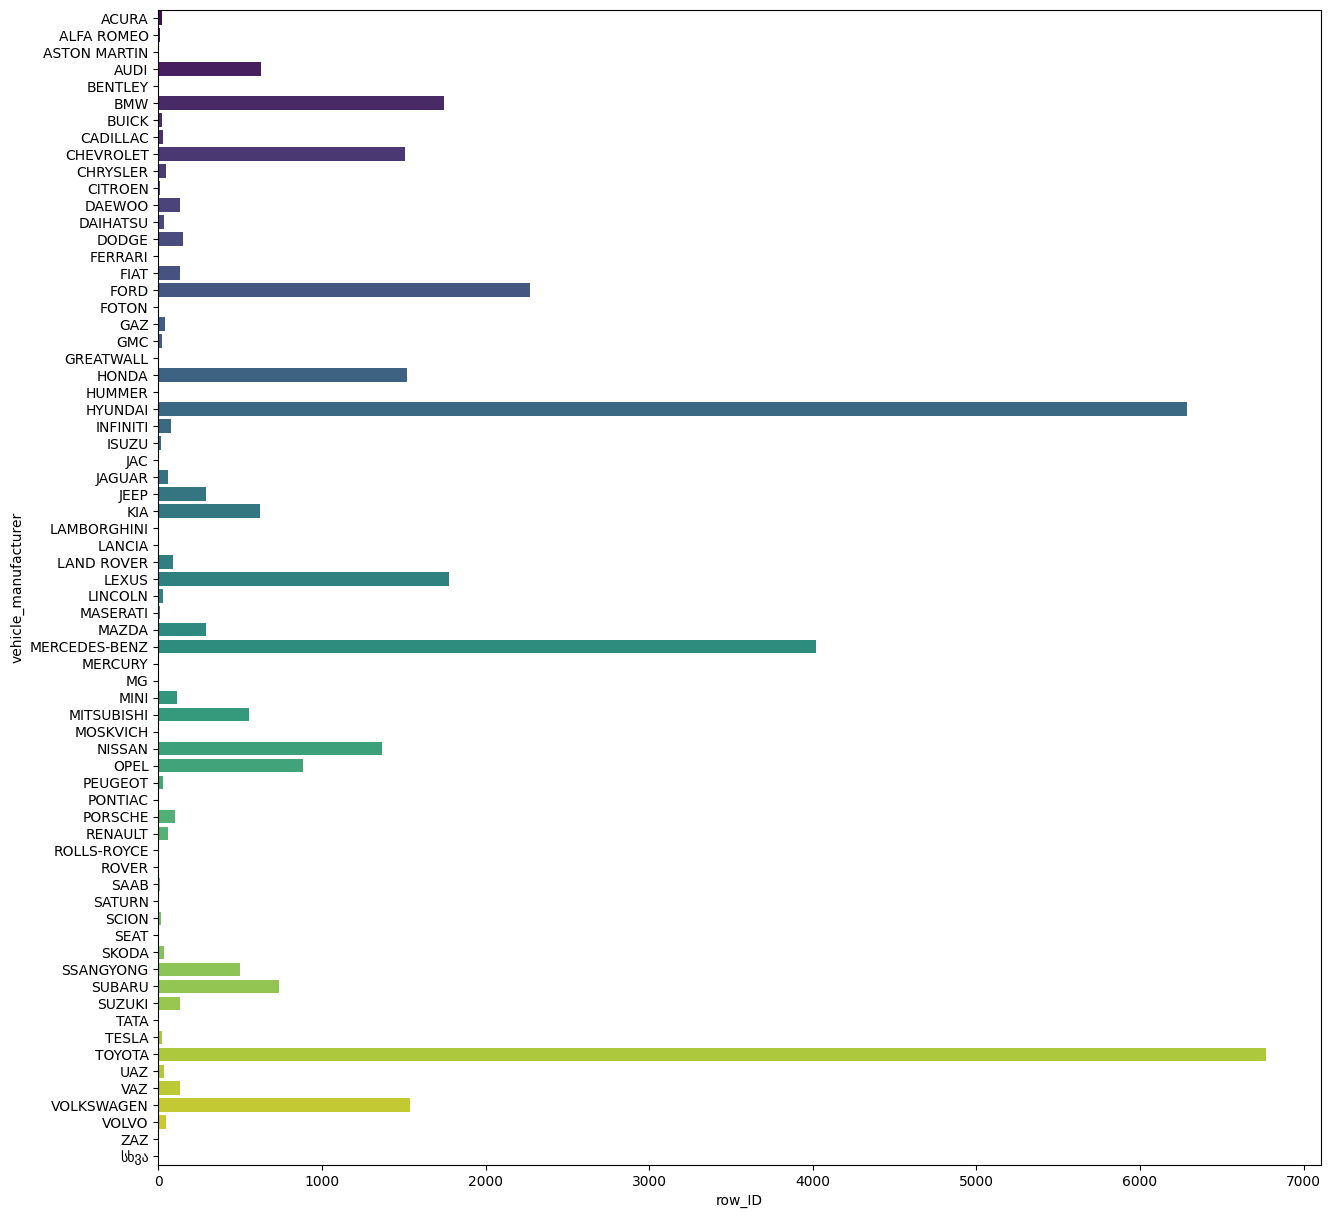

In [8]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.barplot(data=df.groupby('vehicle_manufacturer')[['row_ID']].count().reset_index(),
            y='vehicle_manufacturer',
            x='row_ID',
            palette='viridis')
plt.show()

In [9]:
df_rent = df.loc[df['deal_type'] == 'For Rent']
df_sale = df.loc[df['deal_type'] == 'For Sale']
print(f"всего машин для ренты {df_rent['final_price'].count()}"
    f", средняя цена {df_rent['final_price'].mean()} ")

print(f"всего машин на продажу {df_sale['final_price'].count()}"
    f", средняя цена {df_sale['final_price'].mean()} ")

всего машин для ренты 628, средняя цена 233.3264331210191 
всего машин на продажу 34371, средняя цена 6119.87285793256 


посмотрим на пробег машины

(0.0, 100000.0)

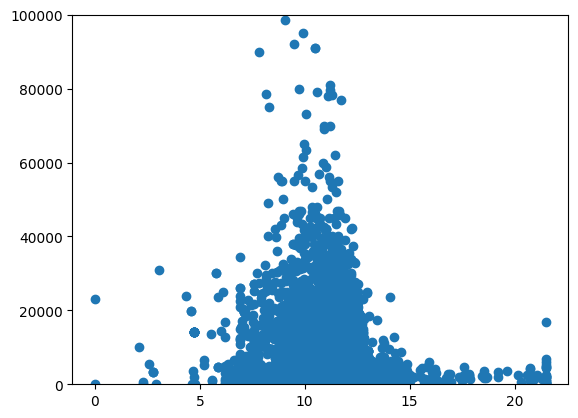

In [10]:
info = df.groupby('current_mileage')['final_price'].mean()

bar = info.to_dict()

plt.plot(np.log(df['current_mileage'].to_numpy()), df['final_price'].to_numpy(), linestyle='', marker='o')
plt.ylim([0, 100000])

пробег больше 650000 можно считать выбросом

In [11]:
df.loc[df['current_mileage'] > 650000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
316,316,SUZUKI,Grand Vitara,Jeep,2147483647,1999,Manual,4/5,Left wheel,Carnelian red,Black,1,For Rent,2073.0
358,358,MERCEDES-BENZ,E 200,Sedan,2844468,2001,Manual,4/5,Left wheel,Blue,Black,0,For Sale,3500.0
556,556,HYUNDAI,Sonata,Sedan,669145,2015,Automatic,4/5,Left wheel,White,Black,1,For Sale,3500.0
613,613,SUBARU,Legacy,Universal,1980000,2005,Tiptronic,4/5,Right-hand drive,Black,Black,0,For Sale,2200.0
660,660,MITSUBISHI,Pajero,Jeep,1111111,1996,Automatic,4/5,Left wheel,Golden,Brown,0,For Sale,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34360,34360,FORD,Transit,Microbus,1111111,2000,Manual,2/3,Left wheel,White,Grey,0,For Sale,4100.0
34429,34429,VOLKSWAGEN,Jetta,Sedan,750000,2014,Automatic,4/5,Left wheel,Grey,Black,1,For Sale,6000.0
34752,34752,HYUNDAI,Sonata,Sedan,742997,2012,Automatic,4/5,Left wheel,Silver,Black,1,For Sale,2100.0
34791,34791,MERCEDES-BENZ,200,Sedan,3000000,1998,Manual,4/5,Left wheel,Green,Black,0,For Sale,2000.0


Видно, что цифры нереалистичные, поэтому заменим их на средний пробег для машин соответствующего года

In [12]:
#train
df['current_mileage'] = df.groupby('vehicle_year')['current_mileage'].transform(
    lambda x: x.mask(x > 650000, x.where(x <= 650000).mean())
)
df.loc[df['current_mileage'].isnull(), 'current_mileage'] = 0
df['current_mileage'] = df['current_mileage'].round().astype(int)
df['current_mileage'] = df['current_mileage'].apply(np.log)
df.loc[df['current_mileage'] < 0, 'current_mileage'] = 0

#test
df_t['current_mileage'] = df_t.groupby('vehicle_year')['current_mileage'].transform(
    lambda x: x.mask(x > 650000, x.where(x <= 650000).mean())
)
df_t.loc[df_t['current_mileage'].isnull(), 'current_mileage'] = 0
df_t['current_mileage'] = df_t['current_mileage'].round().astype(int)
df_t['current_mileage'] = df_t['current_mileage'].apply(np.log)
df_t.loc[df_t['current_mileage'] < 0, 'current_mileage'] = 0

Посмотрим на пропуски в моделях машин

In [13]:
df[df['vehicle_model'].isnull()]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
6300,6300,სხვა,NaN,Universal,0.000000,2007,Tiptronic,2/3,Left wheel,Blue,Black,1,For Sale,2500.0
11796,11796,HONDA,NaN,Hatchback,12.037062,2012,Automatic,4/5,Right-hand drive,White,Black,1,For Sale,4200.0
14755,14755,სხვა,NaN,Limousine,5.991465,2019,Automatic,>5,Left wheel,White,Black,1,For Sale,14500.0
20642,20642,JAC,NaN,Microbus,6.907755,2019,Manual,4/5,Left wheel,White,Grey,1,For Sale,22500.0
22563,22563,სხვა,NaN,Sedan,10.401076,1972,Manual,4/5,Left wheel,Green,Beige,0,For Sale,1.0
32928,32928,FOTON,NaN,Sedan,11.512925,2001,Manual,4/5,Left wheel,Green,Golden,0,For Sale,223.0


Pаменим модель на название производителя.


In [14]:
df.loc[df['vehicle_model'].isnull(), 'vehicle_model'] = df['vehicle_manufacturer']

df_t.loc[df_t['vehicle_model'].isnull(), 'vehicle_model'] = df_t['vehicle_manufacturer']

Заполним пропуски, основываясь на похожих данных в датасете.

Цвет машины мы заполним самым частым цветом данного производителя

In [15]:
df['vehicle_color'] = df.groupby('vehicle_manufacturer')['vehicle_color'].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)

df_t['vehicle_color'] = df_t.groupby('vehicle_manufacturer')['vehicle_color'].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)

заполняем пропуски в цвете интерьера машины поступаем аналогично

In [16]:
df['vehicle_interior_color'] = df.groupby('vehicle_manufacturer')['vehicle_interior_color'].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)

df_t['vehicle_interior_color'] = df_t.groupby('vehicle_manufacturer')['vehicle_interior_color'].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)

Для количества дверей же будем учитывать не самую частую по производителю, а самую частую по типу машины

In [17]:
df['doors_cnt'] = df.groupby('vehicle_category')['doors_cnt'].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)

df_t['doors_cnt'] = df_t.groupby('vehicle_category')['doors_cnt'].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)

Итоговая проверка заполнения значений

In [18]:
df.isna().sum()

row_ID                    0
vehicle_manufacturer      0
vehicle_model             0
vehicle_category          0
current_mileage           0
vehicle_year              0
vehicle_gearbox_type      0
doors_cnt                 0
wheels                    0
vehicle_color             0
vehicle_interior_color    0
car_leather_interior      0
deal_type                 0
final_price               0
dtype: int64

Работа с выбросами

<Axes: xlabel='final_price'>

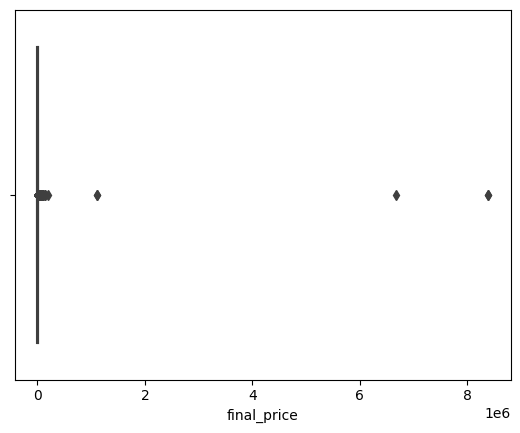

In [19]:
import seaborn as sns

sns.boxplot(x=df['final_price'])

посмотрим на машины с ценой больше 100000$

In [20]:
df.loc[df['final_price'] > 100000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
3877,3877,VOLKSWAGEN,Golf,Sedan,8.945854,2007,Tiptronic,4/5,Left wheel,Red,Golden,0,For Sale,8388607.0
12136,12136,BMW,328,Sedan,12.413087,2008,Automatic,4/5,Left wheel,Sky blue,Yellow,1,For Sale,1111111.0
15291,15291,MERCEDES-BENZ,G 65 AMG 63AMG,Jeep,0.000000,2020,Tiptronic,4/5,Left wheel,Black,Brown,1,For Sale,200000.0
19820,19820,PORSCHE,Panamera Turbo S E-Hyb,Sedan,9.680344,2017,Tiptronic,4/5,Left wheel,Carnelian red,White,1,For Sale,135000.0
20577,20577,BMW,520,Sedan,11.858457,1992,Manual,4/5,Left wheel,Grey,Black,1,For Sale,111111.0
24980,24980,SUBARU,Legacy,Sedan,11.482466,2003,Manual,4/5,Right-hand drive,Silver,Black,1,For Sale,1111111.0
32442,32442,OPEL,Combo,Goods wagon,11.512915,1999,Manual,2/3,Left wheel,Blue,Black,0,For Sale,8388607.0
32937,32937,LAMBORGHINI,Gallardo,Coupe,10.165852,2013,Tiptronic,2/3,Left wheel,Yellow,Black,1,For Sale,135000.0
34052,34052,MERCEDES-BENZ,ML 320,Jeep,11.994536,2002,Tiptronic,4/5,Left wheel,White,Black,1,For Sale,6666666.0


In [21]:
df = df.loc[df['final_price'] < 200000]

# Построение модели


In [22]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [23]:
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import warnings


warnings. filterwarnings ("ignore")

N_FOLDS = 3

def get_metrics(y_test: np.ndarray,
                 y_pred: np.ndarray,
                 X_test: np.ndarray,
                 name: str = None):

  #Генерация таблицы с метриками
  df_metrics = pd.DataFrame()
  df_metrics ['model'] = [name]
  df_metrics ['MAE'] = mean_absolute_error(y_test, y_pred)
  df_metrics['MSE'] = mean_squared_error(y_test, y_pred)

  return df_metrics

In [24]:
X = df.drop(['final_price','row_ID'], axis=1)
y = df['final_price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=10)

eval_set = [(X_test, y_test)]

In [25]:


model = CatBoostRegressor(iterations=50000, depth=10, learning_rate=0.05, loss_function='MAE',
                          cat_features=['vehicle_manufacturer', 'vehicle_model', 'doors_cnt',
                                       'vehicle_category', 'vehicle_gearbox_type', 'wheels',
                                        'deal_type', 'vehicle_color', 'vehicle_interior_color'])

# Обучим модель
model.fit(X_train, y_train, eval_set=(X_test, y_test),
          early_stopping_rounds=50, verbose=100)

# Сделаем предсказания на обучающей выборке
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print(mae)

0:	learn: 3642.9904889	test: 3708.8382878	best: 3708.8382878 (0)	total: 307ms	remaining: 4h 16m 1s
100:	learn: 2149.4974426	test: 2178.1537760	best: 2178.1537760 (100)	total: 22s	remaining: 3h 49s
200:	learn: 1953.2480789	test: 2044.1619068	best: 2044.1619068 (200)	total: 42.6s	remaining: 2h 55m 44s
300:	learn: 1793.9072562	test: 1943.0839745	best: 1943.0573294 (299)	total: 54.8s	remaining: 2h 30m 53s
400:	learn: 1682.9842051	test: 1890.5032429	best: 1890.4736362 (399)	total: 1m 7s	remaining: 2h 18m 44s
500:	learn: 1613.2515817	test: 1861.8297080	best: 1861.8297080 (500)	total: 1m 19s	remaining: 2h 11m 7s
600:	learn: 1565.4673762	test: 1842.4165465	best: 1842.4165465 (600)	total: 1m 31s	remaining: 2h 5m 46s
700:	learn: 1515.9607359	test: 1830.0379474	best: 1829.9512825 (698)	total: 1m 44s	remaining: 2h 2m 25s
800:	learn: 1482.8574997	test: 1821.7221677	best: 1821.7212568 (799)	total: 1m 58s	remaining: 2h 57s
900:	learn: 1449.6347061	test: 1814.0134848	best: 1813.6731989 (897)	total: 2m

In [26]:
metrics = get_metrics(y_test, predictions, X_test, 'CatBoostRegressor')
metrics

,model,MAE,MSE
0,CatBoostRegressor,1782.153506,1.676154e+07


# Повторная предобработка. Кодирование

In [27]:
#для трейна
df['deal_type'] = df['deal_type'].apply(lambda x: 1 if x == 'For Sale' else 0)

#для валидационного датасета
df_t['deal_type'] = df_t['deal_type'].apply(lambda x: 1 if x == 'For Sale' else 0)

#словари для преобразования
vehicle_manufacturer_num = df.groupby('vehicle_manufacturer')['final_price'].mean().astype(int).to_dict()
vehicle_model_num = df.groupby('vehicle_model')['final_price'].mean().astype(int).to_dict()
vehicle_category_num = df.groupby('vehicle_category')['final_price'].mean().astype(int).to_dict()
vehicle_gearbox_type_num = df.groupby('vehicle_gearbox_type')['final_price'].mean().astype(int).to_dict()
doors_cnt_num = df.groupby('doors_cnt')['final_price'].mean().astype(int).to_dict()
wheels_num = df.groupby('wheels')['final_price'].mean().astype(int).to_dict()
vehicle_color_num = df.groupby('vehicle_color')['final_price'].mean().astype(int).to_dict()
vehicle_interior_color_num = df.groupby('vehicle_interior_color')['final_price'].mean().astype(int).to_dict()

num_dict = {'vehicle_manufacturer': vehicle_manufacturer_num,
            'vehicle_model': vehicle_model_num,
            'vehicle_category': vehicle_category_num,
            'vehicle_gearbox_type': vehicle_gearbox_type_num,
            'doors_cnt': doors_cnt_num,
            'wheels': wheels_num,
            'vehicle_color': vehicle_color_num,
            'vehicle_interior_color': vehicle_interior_color_num}

#для трейна
num_df = df.replace(num_dict)

#для валидационного датасета
num_test_df = df_t.replace(num_dict)

Пробуем снова

In [28]:
y = num_df['final_price']
X = num_df.drop(['final_price', 'row_ID'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=137)

model = CatBoostRegressor(iterations=50000, depth=10, learning_rate=0.05, loss_function='MAE')

# Обучим модель
model.fit(X_train, y_train, eval_set=(X_test, y_test),
          early_stopping_rounds=50, verbose=100)

# Сделаем предсказания на обучающей выборке
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print(mae)

0:	learn: 3664.3332298	test: 3614.3362243	best: 3614.3362243 (0)	total: 20.2ms	remaining: 16m 48s
100:	learn: 2042.6282134	test: 2089.9429761	best: 2089.9429761 (100)	total: 1.7s	remaining: 13m 58s
200:	learn: 1840.2991600	test: 1933.4846827	best: 1933.4846827 (200)	total: 3.37s	remaining: 13m 54s
300:	learn: 1693.5124872	test: 1831.2696952	best: 1831.2696952 (300)	total: 5.38s	remaining: 14m 47s
400:	learn: 1615.7030263	test: 1778.1288106	best: 1778.1288106 (400)	total: 8.49s	remaining: 17m 30s
500:	learn: 1569.8626725	test: 1746.8763623	best: 1746.8763623 (500)	total: 10.2s	remaining: 16m 45s
600:	learn: 1515.3358904	test: 1712.4155090	best: 1712.4155090 (600)	total: 11.9s	remaining: 16m 14s
700:	learn: 1481.7194015	test: 1694.1660302	best: 1694.1660302 (700)	total: 13.5s	remaining: 15m 52s
800:	learn: 1453.2381773	test: 1678.0195858	best: 1678.0195858 (800)	total: 15.2s	remaining: 15m 35s
900:	learn: 1434.2991035	test: 1667.9977608	best: 1667.9977608 (900)	total: 16.9s	remaining: 15

In [29]:
metrics = get_metrics(y_test, predictions, X_test, 'CatBoostRegressor_2')
metrics

,model,MAE,MSE
0,CatBoostRegressor_2,1572.131231,1.149037e+07


Попробуем вместо catboost использовать dart booster из XGBoost, т.к. у нас не осталось категориальных переменных и catboost теперь не нужен.

In [30]:
import xgboost as xgb

XGmodel = xgb.XGBRegressor(n_estimators=2000, max_depth=10, learning_rate=0.05, early_stopping_rounds=50,
                         booster='dart', eval_metric=mean_absolute_error, verbosity=0)

XGmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

y_pred = XGmodel.predict(X_test)

# Оценка модели по MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')


[0]	validation_0-rmse:5894.93324	validation_0-mean_absolute_error:3782.72925
[100]	validation_0-rmse:3403.05598	validation_0-mean_absolute_error:1776.75012
[200]	validation_0-rmse:3359.25416	validation_0-mean_absolute_error:1678.22156
[300]	validation_0-rmse:3331.94799	validation_0-mean_absolute_error:1612.20459
[400]	validation_0-rmse:3323.98133	validation_0-mean_absolute_error:1571.53503
[500]	validation_0-rmse:3320.80940	validation_0-mean_absolute_error:1543.12476
[600]	validation_0-rmse:3319.66571	validation_0-mean_absolute_error:1523.06018
[700]	validation_0-rmse:3323.74794	validation_0-mean_absolute_error:1509.39307
[800]	validation_0-rmse:3328.45476	validation_0-mean_absolute_error:1500.79443
[900]	validation_0-rmse:3333.01550	validation_0-mean_absolute_error:1493.63391
[1000]	validation_0-rmse:3335.51403	validation_0-mean_absolute_error:1488.81580
[1100]	validation_0-rmse:3338.27185	validation_0-mean_absolute_error:1483.33765
[1200]	validation_0-rmse:3340.87801	validation_0-mea

Лучшие результаты, эту модель мы и будем использовать на валидационной выборке.

# Предобработка валидационного датасета

Единственную строку, где vehicle_manufacturer не указан (np.nan) мы сразу зануляем.

In [31]:
num_test_df.loc[df_t['row_ID'] == 37254, ['vehicle_manufacturer', 'vehicle_model', 'vehicle_category', 'vehicle_gearbox_type',
                                        'doors_cnt', 'wheels', 'vehicle_color', 'vehicle_interior_color', 'deal_type']] = [
    0, 0, 0, 0, 0, 0, 0, 0, 1
]

Посмотрим, в каких признаках в тестовом датасете присутствуют новые классы (для этого сравним два множества уникальных классов для каждого столбца с категориальными переменными в train и test):

In [32]:
print(set(df_t['vehicle_manufacturer'].tolist()) - set(df['vehicle_manufacturer'].tolist()))

{'CHERY', 'HAVAL', nan}


In [33]:
print(set(df_t['vehicle_model'].tolist()) - set(df['vehicle_model'].tolist()))

{'Prius Full', 'GS 450 hybrid', 'X5 3.0i', 'Accent GS', 'Defender', 'ML 350 3.7', 'Cooper S Cabrio R56', 'CR-Z ჰიბრიდი', 'ASX', 'Camry Hybrid SE', 'C 180 Compresor', 'Impreza wr', 'Prius ....', 'Mustang cabrio', 'FIT L', 'Freelander 1.7 turbo diz', 'A4 b7', 'Doblo macivari', 'Mustang GT', 'A8 L', 'Cr-v EXL', 'Sprinter 211 CDI', 'X5 3.5i', 'E 320 211', 'C 200 2003', 'FIT \tNAVI PREMIUM', 'Jetta 2.0', 'ML 320 4x4', 'X-Trail 4X4', '640 M', 'Sprinter 313 CD', 'Lancer GTS', 'Civic Hybrid ', 'CT 200h F SPORT', 'Xsara picasso', 'Vito 109', '320 diesel', 'XC90 3.2 L', 'A1', 'Crafter 2.5 TDI', 'Mazda 6 TOURING', 'Camry limited', 'Jetta s', 'C 280 SPORT', '640 GRAN-COUPE', 'X5 დიზელი', 'Sprinter 411', 'Acty Van', 'Demio mazda2', 'GLA 250 4MATIC', 'Vito 110d', 'Traverse LT', 'Elantra 1.8', 'B 170 Edition One', 'GLS 450 AMG', 'Elantra 2016', 'Elgrand VIP CLASS', '325 გაცვლა', 'GL 350 BLUTEC', 'C-MAX plug-in', 'Yaris AYGO', 'Sonata hibrid', 'Explorer EDIBAUER', 'Lacetti CDI', 'Paseo', 'Prius Xsp', 

уникальные значения есть только в vehicle_manufacturer и vehicle_model.

Для vehicle_manufacturer мы возьмем моду по этому же столбцу в обучающей выборке

In [35]:
num_test_df.loc[num_test_df['vehicle_manufacturer'].apply(lambda x: isinstance(x, str)),
                'vehicle_manufacturer'] = num_df['vehicle_manufacturer'].mode()[0].astype(int)

Для vehicle_model мы берем моду (самый частый автомобиль у данного производителя) из обучающей выборки

In [36]:
#составляем словарь {производитель: самая часто встречающаяся модель машины для этого производителя}
mode_mapping = num_df.groupby('vehicle_manufacturer')['vehicle_model'].agg(lambda x: x.mode().iloc[0]).to_dict()

for vehicle_manufacturer, mode_of_vehicle_models in mode_mapping.items():
    num_test_df.loc[(num_test_df['vehicle_manufacturer'] == vehicle_manufacturer)&(num_test_df['vehicle_model'].apply(
        lambda x: isinstance(x, str)
    )), 'vehicle_model'] = mode_of_vehicle_models

In [37]:
num_test_df.loc[num_test_df['vehicle_model'].apply(lambda x: isinstance(x, str))]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type


In [38]:
num_test_df = num_test_df.drop('row_ID', axis=1)

In [39]:
num_test_df['vehicle_manufacturer'] = num_test_df['vehicle_manufacturer'].astype(int)
num_test_df['vehicle_model'] = num_test_df['vehicle_model'].astype(int)

In [40]:
num_test_df

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type
0,4277,3029,3305.0,12.687674,2012,4958.0,5279.0,5487.0,6041.0,5287.0,1,1
1,7624,4783,4441.0,11.626254,2013,7943.0,5279.0,5487.0,6041.0,5287.0,1,1
2,5658,15725,7327.0,9.736252,2018,4958.0,5279.0,5487.0,6296.0,5287.0,1,1
3,5658,2721,3305.0,12.620636,2012,4958.0,5279.0,5487.0,5316.0,5287.0,1,1
4,4277,7848,7327.0,7.495542,2002,3561.0,5279.0,5487.0,4664.0,5287.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10692,5283,92,7327.0,12.674982,2010,4958.0,5279.0,5487.0,4736.0,5287.0,1,1
10693,5839,3196,4441.0,11.588033,2013,4958.0,5279.0,5487.0,6041.0,5287.0,1,1
10694,14843,19985,7327.0,11.918391,2011,7943.0,5279.0,5487.0,5780.0,5476.0,1,1
10695,4277,3029,3305.0,11.918391,2010,4788.0,5279.0,5487.0,4664.0,6394.0,0,1


In [41]:
final_result = XGmodel.predict(num_test_df)

# Постобработка

In [42]:
sample_submission = pd.read_csv('sample_submission.csv')


sample_submission['final_price'] = final_result
sample_submission.loc[sample_submission['row_ID'] == 37254, 'final_price'] = 0

Заменим отрицательные значения в валидационной выборке не на 0, а на значение чуть больше 0, т.к. машин за 0$ в датасете нет.

In [43]:
df.loc[df['final_price'] < 300]['final_price'].mean()

128.0109157064888

In [44]:
sample_submission.loc[sample_submission['final_price'] < 0, 'final_price'] = 40

In [45]:
sample_submission.to_csv('sample_submission.csv', index=False)
